## Imports

In [2]:
# Standard Python Libraries
import os
import glob
import json
import pickle
import random
import xml.etree.ElementTree as ET
import gc
import csv

# Data Processing
import numpy as np
import pandas as pd

# Image Processing and Visualization
import cv2
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image

# PyTorch and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights

# Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

# External Libraries and Tools
from ultralytics import YOLO
import albumentations as A
import optuna
import supervision as sv
from tqdm import tqdm

# Custom Utilities
from VisualizationTools.get_data_from_XML import XML_preprocessor, get_category
from VisualizationTools.get_gt import get_gt
from VisualizationTools.getUID import getUID_path
from VisualizationTools.utils import loadFileInformation

# Matplotlib Configuration
%matplotlib inline


/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Train (LUNG-PET-Dx)

### YOLOv8n - 16 batch (LUNG-PET-Dx)

**Backbone:(0)**

The backbone is responsible for extracting features from the input image. In your architecture, this includes the initial Conv and C2f blocks.
DenseNet can replace or complement parts of the backbone for richer feature extraction.

**Neck: (9)**

The neck aggregates multi-scale features and prepares them for the head. In your architecture, the neck starts from the SPPF block and includes the Upsample, Concat, and subsequent C2f blocks.

**Head: (22)**

The head outputs the final object detections, including bounding boxes, objectness scores, and class probabilities. This is defined in the Detect module. DenseNet is generally not involved here.


Backbone Integration (Option 1): Replace or insert DenseNet after initial Conv layers or C2f blocks.
Neck Fusion (Option 2): Combine DenseNet and YOLO features in the neck for enhanced representation.
Preferred Layers for Integration:
After layers (1) or (2) in the backbone for replacement.
After the SPPF block in the neck for feature fusion.
These approaches leverage DenseNet’s feature extraction strength while maintaining YOLO’s efficient detection pipeline.

In [2]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')  # Replace with the variant you're using (e.g., 'yolov8s.pt')

print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [3]:
?YOLO.train

Signature: YOLO.train(self, trainer=None, **kwargs: Any)
Docstring:
Trains the model using the specified dataset and training configuration.

This method facilitates model training with a range of customizable settings. It supports training with a
custom trainer or the default training approach. The method handles scenarios such as resuming training
from a checkpoint, integrating with Ultralytics HUB, and updating model and configuration after training.

When using Ultralytics HUB, if the session has a loaded model, the method prioritizes HUB training
arguments and warns if local arguments are provided. It checks for pip updates and combines default
configurations, method-specific defaults, and user-provided arguments to configure the training process.

Args:
    trainer (BaseTrainer | None): Custom trainer instance for model training. If None, uses default.
    **kwargs: Arbitrary keyword arguments for training configuration. Common options include:
        data (str): Path to dataset

### Train Yolov8n

#### YOLOv8n LUNG-PET-Dx

In [4]:
%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/last.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8 model config/lung_cancer_config.yml',  
    epochs=50,                   
    imgsz=512,                   
    batch=16,
    patience=50,
    name='YOLOorig(16batch)',
    resume=True 
)

Model is on device: cpu
Ultralytics 8.3.63 🚀 Python-3.11.4 torch-2.2.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/last.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8 model config/lung_cancer_config.yml, epochs=50, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=lung_cancer_detection_split4(16batch), exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=Non

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/la

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/labe

Plotting labels to runs/detect/lung_cancer_detection_split4(16batch)/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training /Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/last.pt from epoch 31 to 50 total epochs


2025/01/18 22:29:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/01/18 22:29:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/18 22:29:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2025/01/18 22:29:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2025/01/18 22:29:53 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: module 'tensorflow._api.v2.compat.v2.__internal__' has no attribute 'register_load_context_function'
2025/01/18 22:29:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/01

MLflow: logging run_id(2aa89c50f9f04002a57129defe711137) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/lung_cancer_detection_split4(16batch)
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.077     0.5041      1.049          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.271      0.669       0.29      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.141     0.5232      1.075          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.294      0.702      0.325      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.224     0.5532      1.109          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.238      0.666      0.259      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.215     0.5485      1.108         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.271      0.643      0.276       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.206     0.5436      1.107         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.183      0.353      0.213     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.259     0.5664      1.121          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.184      0.315      0.212      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.246     0.5579      1.114          5        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.191      0.373      0.236      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.232     0.5516      1.112         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.296      0.719      0.312      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.216     0.5362      1.101         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.244      0.625      0.248      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.209     0.5364        1.1         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.24      0.648      0.256       0.13


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/Users/catarinasilva/anaconda3/lib/python3.11/site-packages/ultralytics/data/augment.py:1853: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
      41/50         0G      1.176     0.4522       1.11          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.195      0.369      0.256       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.162     0.4453      1.101          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.203      0.366      0.269      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.144     0.4333      1.093          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.229      0.629      0.247      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.133     0.4281       1.09          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.245      0.661      0.271      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.128     0.4246      1.087          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.449      0.337      0.245      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.118     0.4193      1.081          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.222        0.6      0.238      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.109     0.4135      1.073          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.185      0.366      0.207     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.101     0.4099      1.068          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.212      0.306      0.219      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.089     0.4048      1.064          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.472       0.29      0.217      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.086      0.401       1.06          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.471      0.296      0.236      0.113



20 epochs completed in 18.155 hours.
Optimizer stripped from runs/detect/lung_cancer_detection_split4(16batch)/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/lung_cancer_detection_split4(16batch)/weights/best.pt, 6.2MB

Validating runs/detect/lung_cancer_detection_split4(16batch)/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.4 torch-2.2.2 CPU (Apple M1)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2032       2032      0.228      0.846      0.345       0.19
        Adenocarcinoma        508        508     0.0791      0.872      0.319      0.154
  Small Cell Carcinoma        508        508     0.0936      0.896      0.229      0.096
  Large Cell Carcinoma        508        508      0.648      0.713      0.633      0.424
Squamous Cell Carcinoma        508        508     0.0932      0.904      0.198     0.0856
Speed: 0.7ms preprocess, 113.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/lung_cancer_detection_split4(16batch)
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


##### Results

In [5]:
print(dir(results))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ap_class_index', 'box', 'class_result', 'confusion_matrix', 'curves', 'curves_results', 'fitness', 'keys', 'maps', 'mean_results', 'names', 'on_plot', 'plot', 'process', 'results_dict', 'save_dir', 'speed', 'task']


In [11]:
results.results_dict

{'metrics/precision(B)': 0.22838958748891985,
 'metrics/recall(B)': 0.8459645669291338,
 'metrics/mAP50(B)': 0.34493302716710794,
 'metrics/mAP50-95(B)': 0.1898682066451271,
 'fitness': 0.2053746886973252}

In [7]:
results.names

{0: 'Adenocarcinoma',
 1: 'Small Cell Carcinoma',
 2: 'Large Cell Carcinoma',
 3: 'Squamous Cell Carcinoma'}

In [8]:
results.ap_class_index

array([0, 1, 2, 3])

In [9]:
results.curves

['Precision-Recall(B)',
 'F1-Confidence(B)',
 'Precision-Confidence(B)',
 'Recall-Confidence(B)']

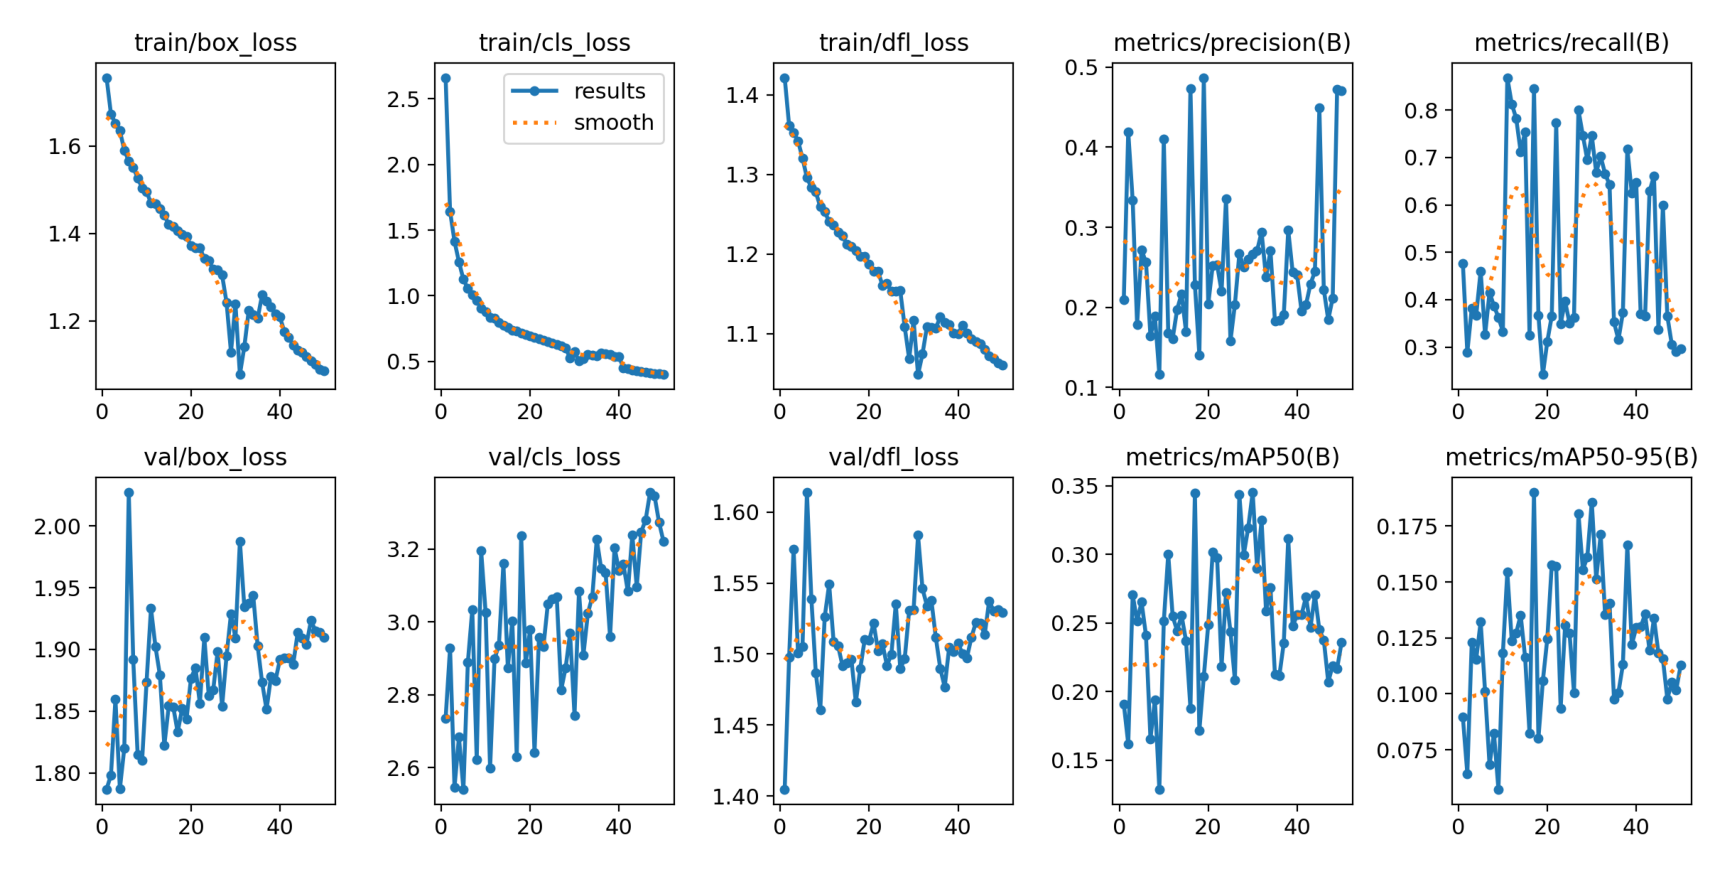

In [12]:
# Load the image
img = mpimg.imread('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/results.png')

plt.figure(figsize=(22,22))
# Display the image
plt.imshow(img)
plt.axis('off')  # Optional: Hide axis
plt.show()

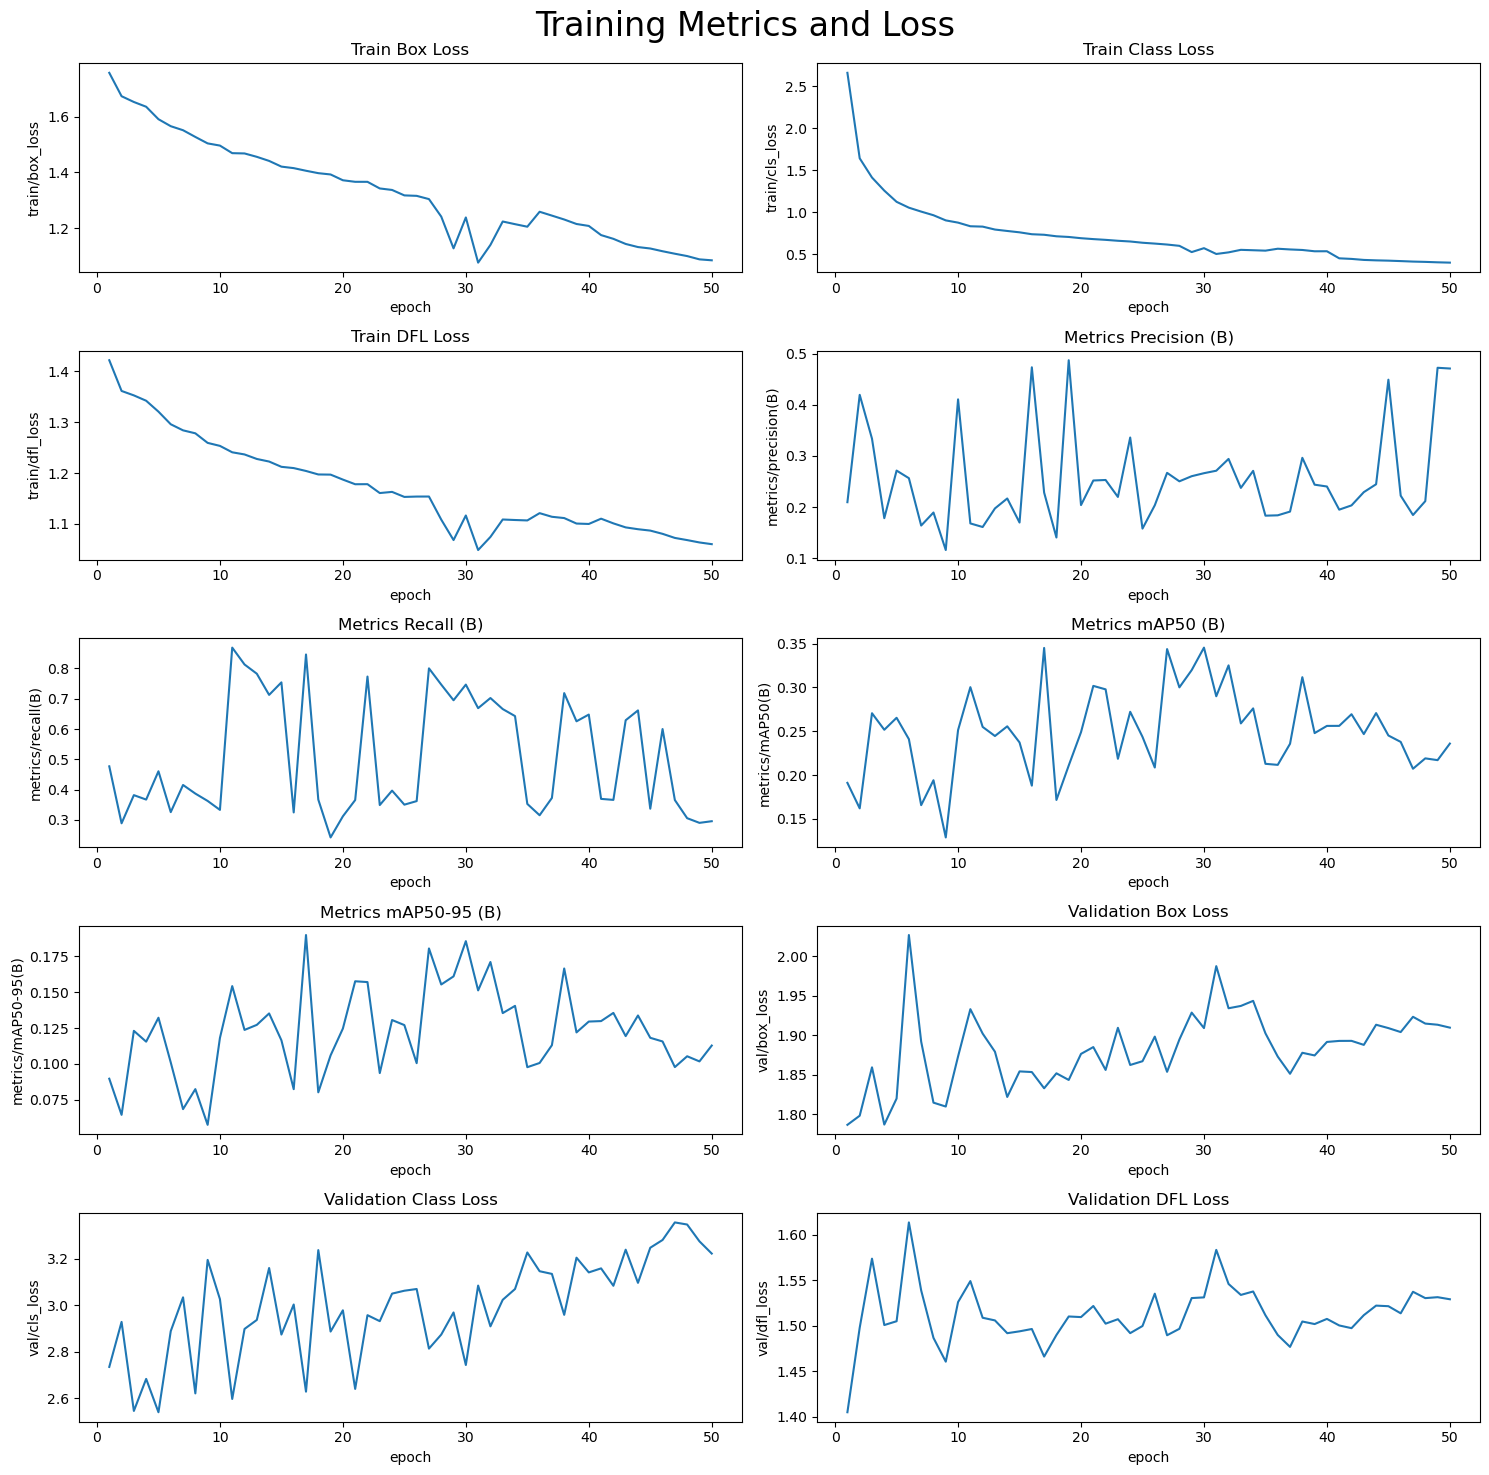

In [13]:
df = pd.read_csv('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

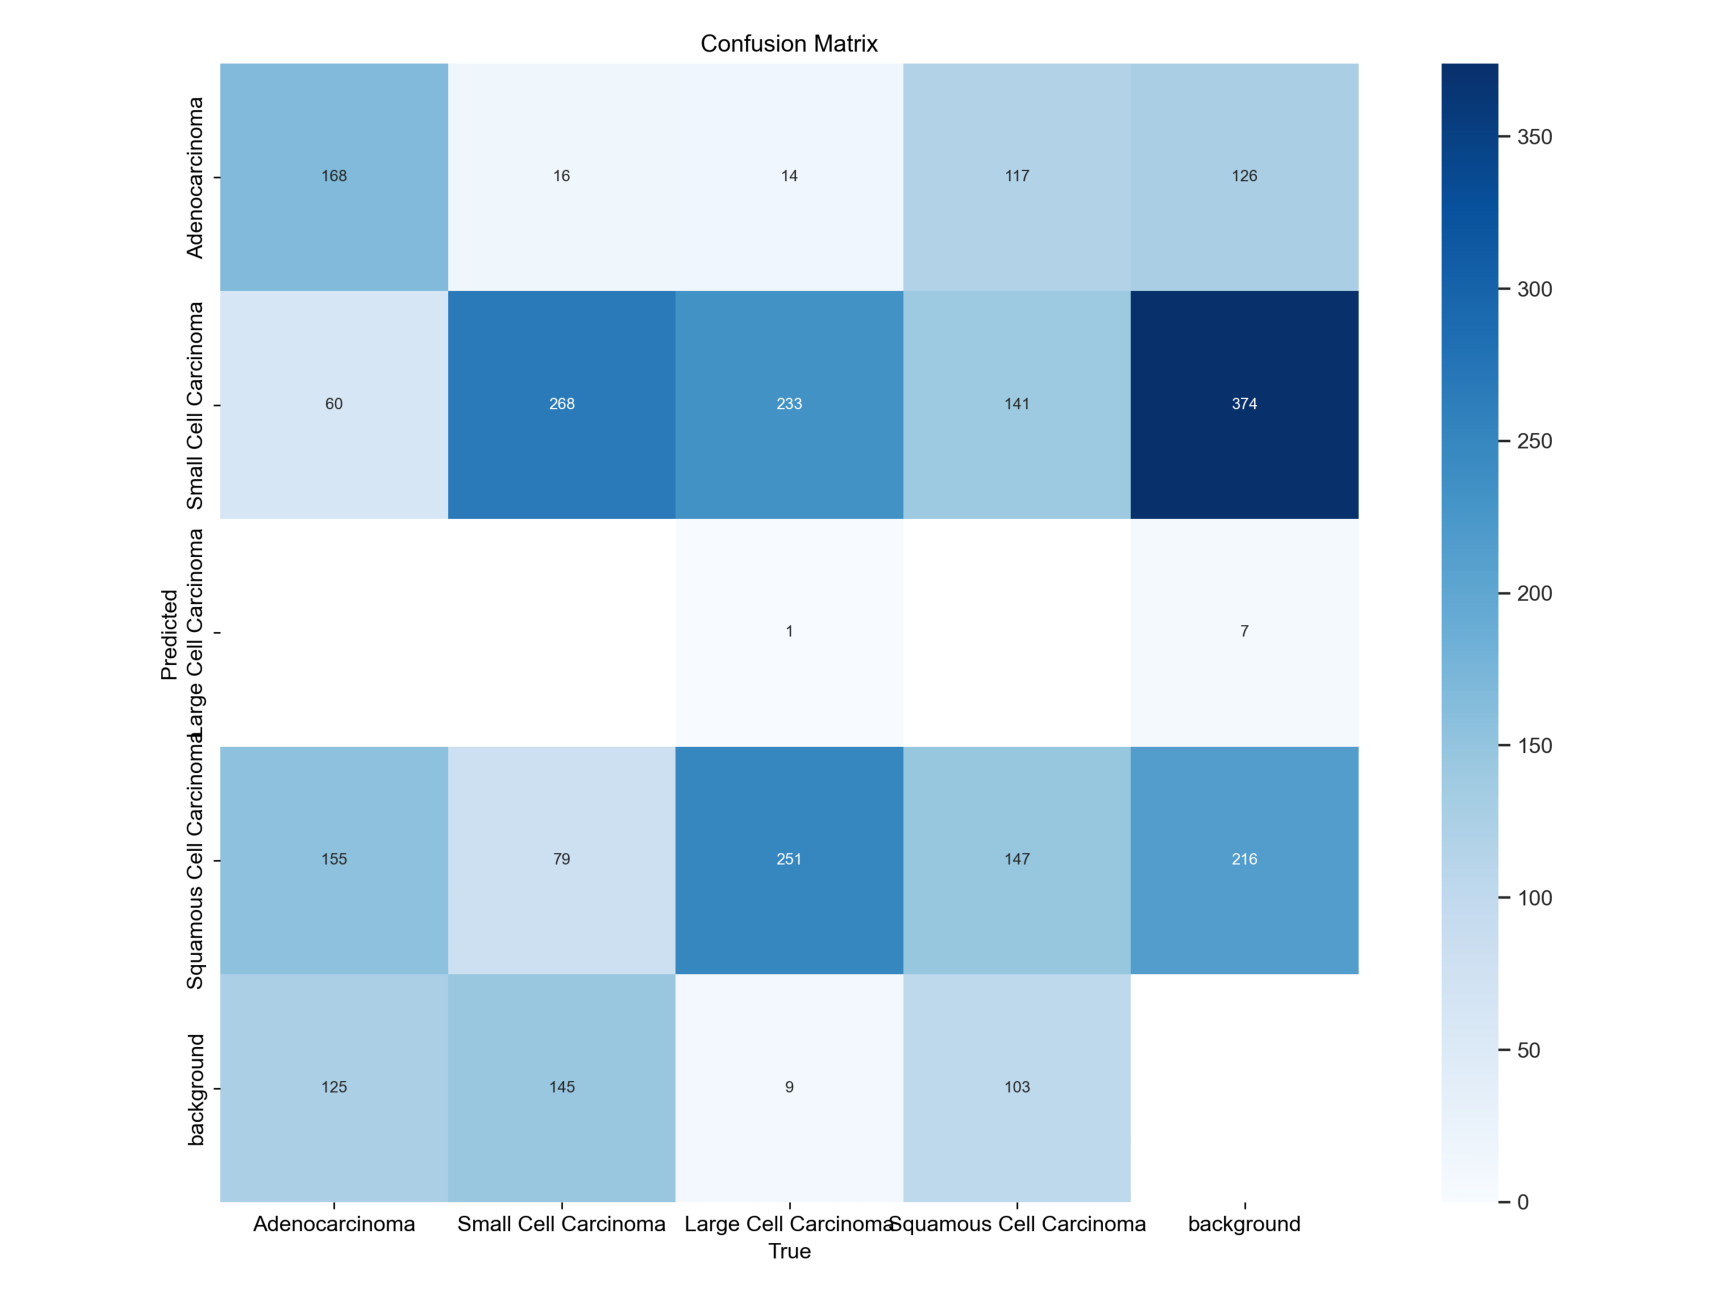

In [14]:
# Load the image
img = mpimg.imread('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/confusion_matrix.png')

plt.figure(figsize=(14,14))
# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

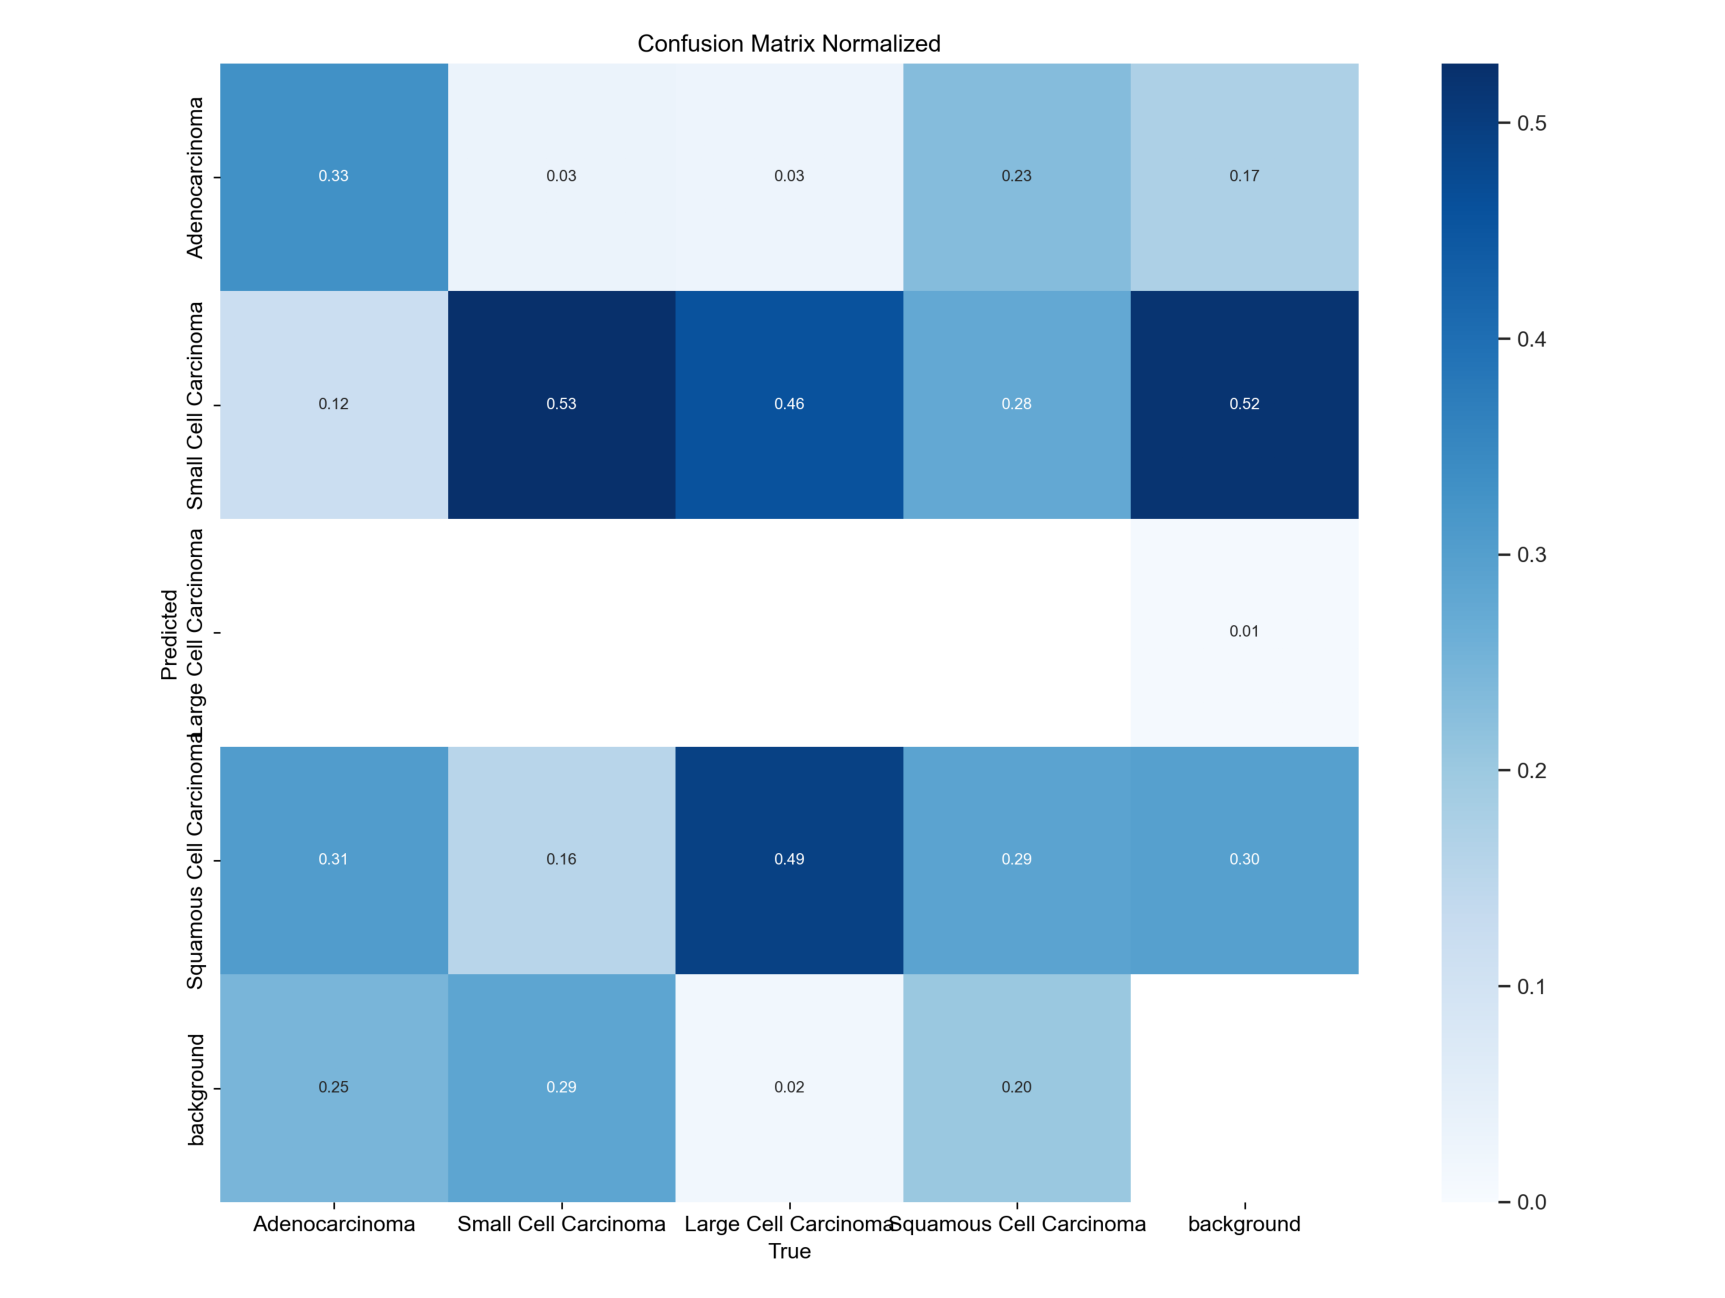

In [16]:
# Load the image
img = mpimg.imread('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/confusion_matrix_normalized.png')

plt.figure(figsize=(14,14))
# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Test

#### Best weights

In [17]:
model_best = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/best.pt')

In [18]:
print(dir(model_best))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_check_is_pytorch_model', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_new', '_non_persistent_buffers_set', '_par

In [20]:
%%time

# Load the YOLOv8 model
model_path = '/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/best.pt'
model = YOLO(model_path)

# Check the device the model is running on
print(f"Model is on device: {model.device}")

# Path to the dataset YAML configuration file
data_config = '/Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8 model config/lung_cancer_config.yml'

# Validate the model on the test dataset
results_test = model.val(data=data_config, 
                    split='test',
                    max_det = 1,
                    name='test_YOLO_orig(16batch)',
                    imgsz=512)

Model is on device: cpu
Ultralytics 8.3.63 🚀 Python-3.11.4 torch-2.2.2 CPU (Apple M1)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/labe


val: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1358       1358      0.322      0.312      0.271      0.137
        Adenocarcinoma        475        475      0.646      0.507      0.613      0.307
  Small Cell Carcinoma        354        354      0.277      0.189      0.184      0.103
  Large Cell Carcinoma         43         43          0          0          0          0
Squamous Cell Carcinoma        486        486      0.364      0.551      0.288      0.137
Speed: 0.6ms preprocess, 128.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/test_results_lung_cancer_detection_split4(16batch)
CPU times: user 13min 26s, sys: 5min 32s, total: 18min 59s
Wall time: 3min


In [23]:
results_test.results_dict

{'metrics/precision(B)': 0.321652117076197,
 'metrics/recall(B)': 0.3120185717484756,
 'metrics/mAP50(B)': 0.27129392211496395,
 'metrics/mAP50-95(B)': 0.13666216146942395,
 'fitness': 0.15012533753397794}

In [25]:
# Extracting and printing key metrics
metrics = results_test.results_dict
precision = metrics['metrics/precision(B)']
recall = metrics['metrics/recall(B)']
f1 = 2 * (precision * recall) / (precision + recall)
mAP50 = metrics['metrics/mAP50(B)']
mAP50_95 = metrics['metrics/mAP50-95(B)']

print(f"Validation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {mAP50_95:.4f}")

Validation Metrics:
Precision: 0.3217
Recall: 0.3120
F1-score: 0.3168
mAP@0.5: 0.2713
mAP@0.5:0.95: 0.1367


Validation Metrics:
Precision: 0.3217
Recall: 0.3120
F1-score: 0.3168
mAP@0.5: 0.2713
mAP@0.5:0.95: 0.1367

#### Test Predictions

In [27]:
model = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung cancer/runs/detect/lung_cancer_detection_split4(16batch)/weights/best.pt')

random_file = random.choice(os.listdir(f"/Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/images/test"))
file_name = os.path.join(f"/Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/images/test", random_file)

results = model(file_name)

print(results[0])


image 1/1 /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/images/test/G0042_1.3.6.1.4.1.14519.5.2.1.6655.2359.267034097245484951944301301770.jpg: 512x512 1 Squamous Cell Carcinoma, 63.0ms
Speed: 1.1ms preprocess, 63.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Adenocarcinoma', 1: 'Small Cell Carcinoma', 2: 'Large Cell Carcinoma', 3: 'Squamous Cell Carcinoma'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0

Image loaded successfully: /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/images/test/G0042_1.3.6.1.4.1.14519.5.2.1.6655.2359.267034097245484951944301301770.jpg
Displaying image: /Users/catarinasilva/Desktop/Master Thesis/lung cancer/YOLOv8/images/test/G0042_1.3.6.1.4.1.14519.5.2.1.6655.2359.267034097245484951944301301770.jpg


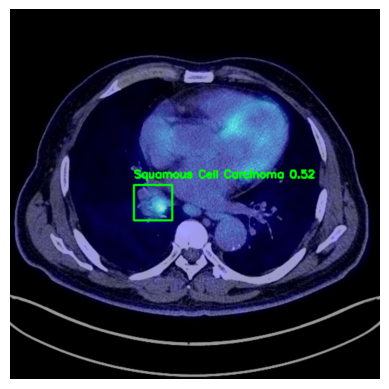

In [32]:
# Load the image
image = cv2.imread(file_name)

# Ensure the image is loaded correctly
if image is None:
    print(f"Failed to load image: {file_name}")
else:
    print(f"Image loaded successfully: {file_name}")

# Create the detections object from the results
detections = sv.Detections.from_ultralytics(results[0])

# Initialize the OrientedBoxAnnotator
oriented_box_annotator = sv.OrientedBoxAnnotator()

# Annotate the image with bounding boxes
annotated_frame = oriented_box_annotator.annotate(
    scene=image,
    detections=detections
)

# Manually drawing bounding boxes to ensure they are visible
for i, box in enumerate(detections.xyxy):
    x1, y1, x2, y2 = map(int, box)  # Convert to integers for OpenCV
    label = detections.data['class_name'][i]
    confidence = detections.confidence[i]

    # Draw a rectangle for each bounding box
    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Add label and confidence score
    text = f"{label} {confidence:.2f}"
    cv2.putText(annotated_frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Resize the annotated frame to the desired resolution
annotated_frame = sv.resize_image(annotated_frame, resolution_wh=(900, 900), keep_aspect_ratio=True)

# Convert the image from BGR to RGB for displaying
annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

# Display the image name and annotated image
print(f"Displaying image: {file_name}")

# Display the annotated image using Matplotlib
plt.imshow(annotated_frame_rgb)
plt.axis('off')  # Hide the axis
plt.show()

In [33]:
print(detections)

Detections(xyxy=array([[     171.64,      243.75,      224.98,      292.82]], dtype=float32), mask=None, confidence=array([    0.51839], dtype=float32), class_id=array([3]), tracker_id=None, data={'class_name': array(['Squamous Cell Carcinoma'], dtype='<U23')})


In [34]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([3.])
conf: tensor([0.5184])
data: tensor([[171.6418, 243.7476, 224.9780, 292.8161,   0.5184,   3.0000]])
id: None
is_track: False
orig_shape: (512, 512)
shape: torch.Size([1, 6])
xywh: tensor([[198.3099, 268.2819,  53.3362,  49.0685]])
xywhn: tensor([[0.3873, 0.5240, 0.1042, 0.0958]])
xyxy: tensor([[171.6418, 243.7476, 224.9780, 292.8161]])
xyxyn: tensor([[0.3352, 0.4761, 0.4394, 0.5719]])

### YOLOv8s - 16 batch (LUNG-PET-Dx)

In [3]:
%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8s.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_small(16batch)_weightdecay1e-3',
    resume=False,
    weight_decay = 1e-3,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75
    
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.81 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(16batch)_weightdecay1e-3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8/la

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8/labe

Plotting labels to runs/detect/YOLOorig_small(16batch)_weightdecay1e-3/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)


2025/03/01 11:14:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/01 11:14:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/01 11:14:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/01 11:14:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/01 11:14:43 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/01 11:14:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(16a9858099ba4923aeca411795bb3b95) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(16batch)_weightdecay1e-3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.642      3.108      1.457          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.286      0.482       0.26      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.562      2.079      1.391          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.285      0.488       0.29      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.541      1.915      1.382          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.411      0.308      0.231      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       1.52      1.746      1.361         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032        0.3      0.465      0.341       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.477      1.547      1.334         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.268      0.352      0.269      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       1.46      1.441      1.318          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.332      0.473      0.286       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.437      1.362      1.297          5        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.14      0.692      0.175     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.409      1.283      1.281         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.174      0.336      0.201     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.388      1.233      1.274         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.346      0.412      0.348      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.375      1.182      1.259         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.149      0.356      0.169     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.346      1.131      1.244         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.164      0.815      0.247      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G       1.35      1.113      1.239         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.283       0.83      0.368      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.332      1.082      1.229         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.218      0.796      0.321      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.318      1.055       1.22         28        512:  


KeyboardInterrupt: 

## Train YOLOv8n + ResNet50 backbone - LUNG-PET-Dx


To integrate ResNet-50 as a backbone into the YOLOv8 architecture, its necessary to replace YOLOv8's default backbone with ResNet-50.

YOLOv8 Architecture Overview
Backbone: Responsible for extracting feature maps from the input image. The default YOLOv8 backbone uses a sequence of Conv, C2f, and SPPF layers.
Neck: Combines multi-scale features using operations like Upsample and Concat.
Head: Outputs predictions for bounding boxes, objectness scores, and class probabilities.



In [1]:
def set_seed(seed=42):
    """Ensure reproducibility by setting the seed across all libraries and enforcing deterministic behavior."""
    # Python random seed
    random.seed(seed)
    
    # Numpy random seed1
    np.random.seed(seed)
    
    # PyTorch random seeds
    torch.manual_seed(seed)
    
    # Set environmental variables for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)

# Example usage
set_seed(42)

# Force full FP32 precision on MPS
torch.set_default_dtype(torch.float32)

# Optional: Disable deterministic behavior (helps with MPS)
torch.use_deterministic_algorithms(False, warn_only=True)

In [27]:
# Path to ResNet50 checkpoint
checkpoint_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth"

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Extract model's weights
resnet_weights = checkpoint["model_state_dict"]

# DSave the extracted weights
resnet_weight_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/ResNet50_weights.pth"
torch.save(resnet_weights, resnet_weight_path)

print(f"ResNet50 weights saved to: {resnet_weight_path}")

✅ ResNet50 weights saved to: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/ResNet50_weights.pth


In [15]:
yolo = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_.yaml')

In [ ]:
yolo.model

### Yolov8n (LUNG-PET-Dx) - 4 frozen layers + default parameters

In [ ]:
# Model with 4 frozen layers + default parameters

yoloresnet50 = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/lung_cancer_detection_ResNet50/weights/last.pt')

results = yoloresnet50.train(
    data='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml',  
    epochs=50,
    imgsz=512,
    batch=8,
    name='lung_cancer_detection_ResNet50',
    pretrained= "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/ResNet50_weights.pth",
    max_det=1,  
    resume=True,
    freeze=4,
    amp=False
)

### Yolov8n (LUNG-PET-Dx) - 4 frozen layers + weight decay= 7e-4 + cls=0.75 + box= 6.5

In [6]:
# Model with 4 frozen layers + weight decay= 7e-4 + cls=0.75 + box= 6.5

yoloresnet50 = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_.yaml')

#yoloresnet50 = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)/weights/last.pt')

results = yoloresnet50.train(
    data='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml',  
    epochs=50,
    patience=15,
    imgsz=512,
    batch=8,
    name='YOLO_ResNet50_weightdecay7e-4(batch8)',
    pretrained= "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/ResNet50_weights.pth",
    max_det=1,  
    resume=False,
    freeze=4,
    amp=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75
)

New https://pypi.org/project/ultralytics/8.3.92 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_.yaml, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml, epochs=50, time=None, patience=15, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLO_ResNet50_weightdecay7e-4(batch8), exist_ok=False, pretrained=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/ResNet50_weights.pth, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=4, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8/la


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8/labe

Plotting labels to runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 99 weight(decay=0.0), 106 weight(decay=0.0007), 105 bias(decay=0.0)


2025/03/18 11:41:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/18 11:41:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/18 11:41:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/18 11:41:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2025/03/18 11:41:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/03/18 11:41:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading 

MLflow: logging run_id(1f77d9b7a2944746892611e04c2e2167) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='model' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/lung_cancer_detection_ResNet50/weights/last.pt' for run ID='1f77d9b7a2944746892611e04c2e2167'. Attempted logging new value '/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_.yaml'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.536       5.49      2.826          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.421      0.197      0.151     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.961      3.516      2.096         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.362      0.354      0.316      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.872      3.212       1.98          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.317      0.248      0.227      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.818      2.984      1.927         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.338      0.212      0.214     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.755      2.747      1.874         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.435      0.313      0.306       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.716      2.559      1.827         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.41       0.23      0.256      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.696      2.448      1.812          4        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.415      0.268      0.282      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G       1.67      2.284      1.796         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.319      0.228      0.202     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.635      2.174      1.763         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.402      0.273      0.283      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.624      2.095      1.751         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.373       0.23      0.252      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G        1.6      1.992      1.728         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.252      0.235      0.174     0.0723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.596      1.951       1.72         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.442      0.278      0.315      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.575      1.867      1.715         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.38      0.274      0.267      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.549      1.826      1.686         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.348      0.262      0.249      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.537      1.764      1.681          7        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.407      0.255      0.268      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.528      1.713      1.674          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.406      0.241      0.256      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.528      1.681      1.671          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.386      0.273      0.272      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.511      1.646      1.653         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.395      0.278      0.288       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.495      1.605      1.644          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.401      0.232       0.27      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.484      1.575      1.633         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.457      0.283      0.312      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.471      1.526      1.621         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032        0.4      0.279      0.267      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.453      1.496       1.61         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.401      0.223      0.247      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.455      1.477      1.607          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.34      0.229      0.207     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.446      1.456      1.602          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.415      0.282      0.286      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G       1.45      1.437      1.602          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.389      0.256      0.258      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.429      1.404      1.585         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.422      0.286       0.28      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.423      1.377      1.581         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.384      0.273      0.266      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.416      1.361      1.579         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.411      0.286      0.273      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.409      1.355      1.572         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.355      0.241      0.226      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.394      1.321      1.558         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.412      0.272      0.277      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.389       1.32      1.551         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032       0.37      0.257      0.246      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.387      1.317      1.557         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.362      0.235      0.227      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.367      1.282      1.535         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.381      0.244       0.24      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.361      1.265      1.535         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.354      0.247      0.223     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.364      1.265      1.544          7        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2032       2032      0.385      0.228      0.243      0.107
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 20, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



35 epochs completed in 142.776 hours.
Optimizer stripped from runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)/weights/last.pt, 129.7MB
Optimizer stripped from runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)/weights/best.pt, 129.7MB

Validating runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
lung_cancer_config_ summary (fused): 146 layers, 64,565,468 parameters, 0 gradients, 163.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2032       2032      0.456      0.283      0.312       0.15
        Adenocarcinoma        508        508       0.44      0.366      0.354      0.169
  Small Cell Carcinoma        508        508      0.241      0.431      0.193     0.0912
  Large Cell Carcinoma        508        508      0.933     0.0827      0.492      0.253
Squamous Cell Carcinoma        508        508      0.209      0.252      0.208     0.0865
Speed: 0.9ms preprocess, 1304.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/YOLO_ResNet50_weightdecay7e-4(batch8)
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Train (LUNG-PET-Dx + NSCLC-Radiomics)

### YOLOv8s - 32 batch (LUNG-PET-Dx + NSCLC-Radiomics) E + G patients

In [4]:
%%time
# Split that was doen befroe + patients E + G

# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8s.pt')  # Used pretrained weights from pretrained small yolo
# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml',  
    epochs=50,                  
    imgsz=512,                   
    batch=32,
    patience=15,
    name='YOLOorig_small(32batch)_E_G',
    resume=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.90 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml, epochs=50, time=None, patience=15, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(32batch)_E_G, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augmen

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/la


Plotting labels to runs/detect/YOLOorig_small(32batch)_E_G/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/15 11:56:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/15 11:56:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/15 11:56:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/15 11:56:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2025/03/15 11:56:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/03/15 11:56:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading 

MLflow: logging run_id(fe1ddbce2477450abbd2ec05348c3d48) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(32batch)_E_G
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.729      3.674      1.482         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.237        0.4      0.203     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.647      2.384      1.417         40        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.289       0.37       0.24      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.627      2.176      1.403         45        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.336      0.385      0.273      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.608      2.057      1.385         25        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.299      0.435      0.267       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.575      1.861      1.359         38        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.367      0.446      0.327      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.533      1.706       1.34         30        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.316      0.419      0.298      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.502      1.601      1.312         39        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.386       0.33      0.307      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.486      1.513      1.302         34        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.408       0.45      0.342      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.468      1.432      1.287         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.305      0.381      0.253      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.457      1.369      1.276         35        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.394      0.455      0.335       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.443      1.355      1.275         44        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.309      0.377      0.259      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.413      1.289      1.253         34        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.343      0.349      0.253      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.407      1.259      1.252         27        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.375      0.394       0.29      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.384      1.217      1.237         44        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.371      0.389      0.283      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G       1.38      1.178       1.23         48        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.347      0.404      0.287      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.357      1.152      1.216         45        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.396       0.41      0.336      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.357       1.13      1.216         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.366      0.402      0.294      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.353      1.115      1.214         31        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.346      0.391      0.283      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.334      1.081      1.206         32        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.32      0.417      0.283      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.322      1.057      1.194         37        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.343       0.38       0.27      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.31      1.038      1.189         40        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.336      0.394      0.285      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.304      1.023      1.185         32        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.318       0.45      0.293      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.299       1.01      1.181         39        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.385      0.402      0.312      0.158
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 52.366 hours.
Optimizer stripped from runs/detect/YOLOorig_small(32batch)_E_G/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/YOLOorig_small(32batch)_E_G/weights/best.pt, 22.5MB

Validating runs/detect/YOLOorig_small(32batch)_E_G/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2040       2040      0.409      0.451      0.341      0.167
        Adenocarcinoma        510        510      0.474      0.417      0.401      0.199
  Small Cell Carcinoma        510        510      0.299      0.684      0.334      0.143
  Large Cell Carcinoma        510        510      0.562      0.429      0.435      0.238
Squamous Cell Carcinoma        510        510        0.3      0.275      0.195     0.0881
Speed: 1.0ms preprocess, 239.0ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/YOLOorig_small(32batch)_E_G
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
CPU times: user 9d 4h 12min 4s, sys: 3d 2h 24min 42s, total: 12d 6h 36min 46s
Wall time: 2d 4h 30min 23s


### YOLOv8n - 32 batch (LUNG-PET-Dx + NSCLC-Radiomics) E + G patients

In [3]:
%%time
# Split that was doen befroe + patients E + G

# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
#model = YOLO('yolov8n.pt')  # Used pretrained weights from pretrained small yolo
model = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_nano(32batch)_E_G/weights/last.pt')
# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml',  
    epochs=50,                  
    imgsz=512,                   
    batch=32,
    patience=15,
    name='YOLOorig_nano(32batch)_E_G',
    resume=True,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.89 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_nano(32batch)_E_G/weights/last.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml, epochs=50, time=None, patience=15, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=YOLOorig_nano(32batch)_E_G, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_nano(32batch)_E_G/weights/last.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/la

Plotting labels to runs/detect/YOLOorig_nano(32batch)_E_G/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)
Resuming training /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_nano(32batch)_E_G/weights/last.pt from epoch 26 to 50 total epochs


2025/03/14 09:52:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/14 09:52:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/14 09:52:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/14 09:52:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2025/03/14 09:52:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/03/14 09:52:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading 

MLflow: logging run_id(31181e82063142289852a66ca8d537f0) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_nano(32batch)_E_G
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G       1.23     0.9624       1.11         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.386      0.427      0.319      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.335      1.067      1.156         40        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.354       0.41        0.3      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.319      1.048       1.15         45        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.336      0.433       0.31      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.306      1.034      1.141         25        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.348      0.425       0.29      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.311      1.023      1.139         38        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.338      0.409      0.288       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.292      1.005      1.134         30        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.353      0.428        0.3      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.277     0.9815      1.123         39        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.341      0.415      0.297      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.272     0.9746      1.123         34        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.405      0.439      0.328      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.267     0.9538      1.119         36        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.409      0.372      0.308      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.259     0.9375      1.116         35        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.348      0.369      0.285      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.258     0.9405      1.114         44        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.353      0.414      0.299      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.236     0.9208      1.106         34        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.345      0.375      0.294      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.241      0.909      1.104         27        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.406      0.421      0.325      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.226     0.8949      1.102         44        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.362      0.382      0.294      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.219     0.8901      1.096         48        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.345      0.444      0.306      0.146


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.194     0.7734      1.104         25        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.336      0.409      0.291      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.187     0.7605      1.098         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.373      0.412      0.306      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.173      0.748      1.096         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.385      0.409      0.312      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.164     0.7375      1.088         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.357      0.435      0.305      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.151     0.7273      1.085         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.367      0.442      0.311      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.144     0.7161      1.079         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.378      0.426      0.309      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G       1.13     0.7061      1.075         25        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.37      0.417       0.31       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.128     0.7004      1.072         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.376      0.423      0.308       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.114     0.6889      1.067         25        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.379      0.422      0.304      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.108     0.6844      1.061         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.386      0.426      0.309       0.15



25 epochs completed in 25.996 hours.
Optimizer stripped from runs/detect/YOLOorig_nano(32batch)_E_G/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/YOLOorig_nano(32batch)_E_G/weights/best.pt, 6.2MB

Validating runs/detect/YOLOorig_nano(32batch)_E_G/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2040       2040      0.456      0.452      0.373      0.181
        Adenocarcinoma        510        510      0.498      0.484      0.403      0.184
  Small Cell Carcinoma        510        510      0.356      0.433      0.349      0.158
  Large Cell Carcinoma        510        510      0.605      0.465      0.446      0.252
Squamous Cell Carcinoma        510        510      0.364      0.427      0.294       0.13
Speed: 0.7ms preprocess, 99.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/YOLOorig_nano(32batch)_E_G
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
CPU times: user 4d 21h 44min 43s, sys: 1d 18h 23min 52s, total: 6d 16h 8min 36s
Wall time: 1d 2h 3min 28s


### YOLOv8n - 16 batch (LUNG-PET-Dx + NSCLC-Radiomics) E + G patients

In [14]:
%%time
# Split that was doen befroe + patients E + G

# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8n.pt')  # Used pretrained weights from pretrained small yolo

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_nano(16batch)_E_G',
    resume=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_nano(16batch)_E_G, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/la

Plotting labels to runs/detect/YOLOorig_nano(16batch)_E_G/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/09 10:59:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/09 10:59:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/09 10:59:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/09 10:59:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/09 10:59:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/09 10:59:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(d4222368b18b47f1bb2394d9ecf17461) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='model' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_small(16batch)_E_G/weights/best.pt' for run ID='d4222368b18b47f1bb2394d9ecf17461'. Attempted logging new value 'yolov8n.pt'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_nano(16batch)_E_G
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.737       4.36      1.413         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.298      0.397      0.273      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.661      2.781      1.357         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.302      0.418      0.288      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.653      2.439      1.355         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.341      0.499      0.341      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.631      2.222      1.349          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.379      0.421      0.307      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.599      2.035      1.316         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.314       0.38      0.262      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.575      1.873      1.301         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.347      0.454      0.321       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.555      1.785      1.286         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.361      0.454      0.311      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.528      1.683      1.273         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.452      0.413      0.332      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.528      1.627      1.272         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.381      0.402      0.307      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.492      1.531      1.242         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.331      0.425      0.298      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.488      1.519      1.244         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.359      0.438      0.295      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.464       1.44      1.236         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.392      0.499      0.357      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.468      1.423      1.233         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.357      0.426      0.311      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.442      1.373      1.223         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.347        0.4      0.287      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.441      1.329      1.213         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.358      0.423      0.317      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.422      1.317      1.208         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.404      0.381      0.284      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.416      1.307      1.204         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.36      0.444      0.289      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.408      1.253      1.202         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.334      0.356       0.25      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.401       1.24      1.196          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.393      0.441      0.337      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.394      1.212      1.191          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.376       0.42      0.342      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.382      1.181      1.182         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.372      0.424      0.317      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G       1.37       1.17      1.174         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.385      0.434      0.312      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.372      1.149      1.178         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.354      0.438      0.311      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.366      1.142      1.171         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.375      0.438      0.307      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.347       1.11      1.169         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.357      0.429      0.304       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.338      1.101      1.159         17        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.358      0.419      0.307      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.334       1.08      1.152         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.355      0.416      0.293      0.141
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



27 epochs completed in 27.470 hours.
Optimizer stripped from runs/detect/YOLOorig_nano(16batch)_E_G/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/YOLOorig_nano(16batch)_E_G/weights/best.pt, 6.2MB

Validating runs/detect/YOLOorig_nano(16batch)_E_G/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2040       2040      0.393      0.496      0.356      0.178
        Adenocarcinoma        510        510      0.398      0.641      0.421      0.204
  Small Cell Carcinoma        510        510      0.329      0.569      0.315      0.132
  Large Cell Carcinoma        510        510       0.57      0.518      0.493      0.292
Squamous Cell Carcinoma        510        510      0.274      0.257      0.195     0.0841
Speed: 0.9ms preprocess, 112.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/YOLOorig_nano(16batch)_E_G
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
CPU times: user 5d 15h 55min 42s, sys: 1d 20h 37min 49s, total: 7d 12h 33min 31s
Wall time: 1d 3h 32min 12s


### YOLOv8s - 16 batch (LUNG-PET-Dx + NSCLC-Radiomics) E + G patients

In [10]:
%%time
# Split that was doen befroe + patients E + G

# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8s.pt')  # Used pretrained weights from pretrained small yolo

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_small(16batch)_E_G',
    resume=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.84 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(16batch)_E_G, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augmen

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/


train: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/la


val: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/labels/val.cache
Plotting labels to runs/detect/YOLOorig_small(16batch)_E_G/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/05 19:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/05 19:35:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/05 19:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/05 19:35:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/05 19:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/05 19:35:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(16a9858099ba4923aeca411795bb3b95) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='data' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml' for run ID='16a9858099ba4923aeca411795bb3b95'. Attempted logging new value '/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(16batch)_E_G
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.731      3.521      1.472         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.299      0.412      0.267      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.664        2.5      1.424         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.35      0.392      0.287      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.649      2.278      1.419         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.294       0.42      0.303       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.611      2.064      1.399          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.336       0.43      0.309      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.589      1.901      1.376         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.34      0.443      0.307      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.554      1.751      1.346         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.444      0.431      0.354      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.535      1.621      1.337         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.384      0.417      0.318      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.497      1.555      1.311         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.406       0.44      0.339      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.493      1.486      1.309         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.326      0.383      0.291      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.462      1.415       1.28         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.347      0.488      0.347      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.459      1.382      1.275         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.363       0.46      0.297      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.427      1.314      1.262         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.362       0.39      0.294      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.424      1.286      1.258         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.386      0.399      0.322      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.405      1.256      1.256         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.36      0.394      0.296      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.398      1.212      1.238         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.301      0.389      0.275      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.381      1.196      1.231         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.361      0.449      0.314      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.373      1.168      1.229         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.369      0.395        0.3      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.361      1.132       1.22         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.388      0.443       0.33      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.352      1.113       1.21          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.434      0.492      0.375      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.335      1.094        1.2          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.408      0.432      0.339      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.325      1.059      1.195         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040       0.37       0.43      0.328      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.309      1.046      1.179         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.397      0.422      0.304      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.311      1.035      1.177         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.376      0.428      0.305      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.308      1.022      1.178         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.446      0.414      0.311      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.285      0.997      1.174         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.391      0.421      0.326      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.272     0.9841      1.166         17        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.402      0.431      0.331      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.265     0.9596      1.156         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.403      0.457       0.34      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G       1.26     0.9489      1.155          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.417       0.46      0.361      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.251     0.9454      1.151         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.414      0.461      0.353      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.248     0.9303      1.143         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.394      0.464      0.345      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.236      0.926      1.137          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.337      0.374      0.291      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.226     0.8941      1.131          7        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.392      0.406       0.32      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G       1.21     0.8857      1.125         16        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.359      0.393      0.294      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G       1.21     0.8738      1.121         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.386      0.372      0.295      0.151
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



34 epochs completed in 74.261 hours.
Optimizer stripped from runs/detect/YOLOorig_small(16batch)_E_G/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/YOLOorig_small(16batch)_E_G/weights/best.pt, 22.5MB

Validating runs/detect/YOLOorig_small(16batch)_E_G/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
Model summary (fused): 72 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       2040       2040      0.436      0.491      0.375      0.187
        Adenocarcinoma        510        510      0.479      0.531      0.396      0.191
  Small Cell Carcinoma        510        510      0.409      0.616      0.429      0.189
  Large Cell Carcinoma        510        510       0.58      0.527      0.494       0.29
Squamous Cell Carcinoma        510        510      0.277      0.289      0.183     0.0765
Speed: 0.8ms preprocess, 240.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/YOLOorig_small(16batch)_E_G
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
CPU times: user 14d 4h 33min 39s, sys: 4d 23h 19min 2s, total: 19d 3h 52min 42s
Wall time: 3d 2h 24min 5s


### YOLOv8s - 16 batch (LUNG-PET-Dx + NSCLC-Radiomics) only E patients

In [9]:
%%time
# Split that was doen before + patients E

# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8s.pt')  # Used pretrained weights from pretrained small yolo

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_small(16batch)_E',
    resume=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.83 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(16batch)_E, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/


train: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/la

val: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8 E/labels/val.cache


Plotting labels to runs/detect/YOLOorig_small(16batch)_E/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/05 14:39:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/05 14:39:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/05 14:39:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/05 14:39:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/05 14:39:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/05 14:39:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(16a9858099ba4923aeca411795bb3b95) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='data' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml' for run ID='16a9858099ba4923aeca411795bb3b95'. Attempted logging new value '/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_E.yaml'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(16batch)_E
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.739      3.599      1.538         18        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.275      0.424      0.267      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.664      2.485      1.484         23        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2040       2040      0.275      0.335      0.249      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.649      2.313      1.477         26        512:  


KeyboardInterrupt: 

### YOLOv8s - 16 batch (LUNG-PET-Dx + NSCLC-Radiomics) only E patients (different split)

In [7]:
# New split + patients E

%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov8s.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets_E.yml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_small(16batch)_2datasets_E',
    resume=False,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75   
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets_E.yml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(16batch)_2datasets_E, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visual

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_2d


train: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_2datasets_E/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_2dat

val: New cache created: /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_2datasets_E/labels/val.cache


Plotting labels to runs/detect/YOLOorig_small(16batch)_2datasets_E/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/04 17:10:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/04 17:10:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/04 17:10:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/04 17:10:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/04 17:10:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/04 17:10:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(16a9858099ba4923aeca411795bb3b95) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='data' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml' for run ID='16a9858099ba4923aeca411795bb3b95'. Attempted logging new value '/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets_E.yml'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(16batch)_2datasets_E
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.735      3.519      1.471         19        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.341      0.336      0.236      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.673       2.41      1.439         24        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.398      0.414      0.366       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.643      2.233      1.432         20        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.284      0.437      0.291      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.618      2.056      1.412         23        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.331      0.392      0.274      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.568      1.862      1.381         19        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.304      0.384      0.278       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.552      1.683      1.371         33        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.299      0.457      0.278      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.524      1.624      1.345         29        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.304      0.366       0.28      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.492      1.528      1.334         30        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.328      0.438      0.325      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.484      1.481      1.321         27        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.308      0.366      0.261      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.458      1.405      1.314         19        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.369      0.432      0.331      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.457      1.379      1.308         23        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2732       2732      0.292      0.402       0.27      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.443      1.313      1.296         19        512:  


KeyboardInterrupt: 

### YOLOv8s - 16 batch (LUNG-PET-Dx + NSCLC-Radiomics) only A + G + E patients (different split)

In [6]:
# 2 datasets + new split and new patients for A, G and E

%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/runs/detect/YOLOorig_small(16batch)_2datasets/weights/last.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets.yml',  
    epochs=50,                  
    imgsz=512,                   
    batch=16,
    patience=15,
    name='YOLOorig_small(16batch)_2datasets',
    resume=True,
    weight_decay = 7e-4,
    box= 7.0,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75
)

Model is on device: cpu
New https://pypi.org/project/ultralytics/8.3.82 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.6.0 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets.yml, epochs=50, time=None, patience=15, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=YOLOorig_small(16batch)_2datasets, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=

train: Scanning /Users/catarinasilva/Desktop/Master Thesis/YOLOv8_2datasets/labe


train: New cache created: /Users/catarinasilva/Desktop/Master Thesis/YOLOv8_2datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /Users/catarinasilva/Desktop/Master Thesis/YOLOv8_2datasets/labels

val: New cache created: /Users/catarinasilva/Desktop/Master Thesis/YOLOv8_2datasets/labels/val.cache
Plotting labels to runs/detect/YOLOorig_small(16batch)_2datasets/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/03/02 17:51:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/02 17:51:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/03/02 17:51:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/03/02 17:51:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/03/02 17:51:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/02 17:51:31 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflo

MLflow: logging run_id(16a9858099ba4923aeca411795bb3b95) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='data' was already logged with value='/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml' for run ID='16a9858099ba4923aeca411795bb3b95'. Attempted logging new value '/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config_2datasets.yml'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/YOLOorig_small(16batch)_2datasets
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.773      3.604      1.523         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.318      0.313      0.268      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G        1.7      2.577      1.475         11        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.451      0.366      0.362      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.693      2.389      1.466         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.378       0.37      0.278      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       1.65      2.212       1.44         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.446      0.415       0.37      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.605      2.003      1.411         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.497      0.368      0.376      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.577      1.876      1.389          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.476      0.425       0.38      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.545      1.738      1.373         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720       0.45      0.435        0.4      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.526      1.682      1.363         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.458      0.403      0.369      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.504      1.606      1.347          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.409        0.4      0.352      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.49      1.533       1.33         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.415      0.427      0.338      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.473      1.494      1.323         14        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.458      0.389      0.324      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.467      1.437      1.312         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.505      0.388      0.349      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.448      1.406      1.303         15        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.459        0.4       0.36      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.445      1.346      1.298         12        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720       0.49      0.383      0.353      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.416      1.299      1.277          8        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.485      0.384      0.359      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.406      1.267      1.276         17        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.498      0.367       0.34      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.404      1.242      1.271         10        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.502      0.376      0.364      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.385      1.216      1.261         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.488      0.336      0.298      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.369      1.177      1.249          7        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.447      0.408      0.335      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.356      1.146       1.24         13        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.458       0.41      0.344      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.349      1.123      1.234          9        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       2720       2720      0.465      0.397      0.343      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.244      1.041      1.231         21        512:  


KeyboardInterrupt: 

## Other Trials

### YOLOv8n - 16 batch (LUNG-PET-Dx) all images

In [10]:
%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('YOLOv8n.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant


# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/configallpatients.yml',  
    epochs=50,                   
    imgsz=512,                   
    batch=16,
    patience=50,
    name='allpatients_16batch',
    amp=False,
    weight_decay = 7e-4,
    box= 7.5,   # Reduce slightly to avoid over-optimizing bounding boxes
    cls= 0.75 
)

New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.4 torch-2.2.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=YOLOv8n.pt, data=/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/configallpatients.yml, epochs=50, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=allpatients_16batch, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classe

train: Scanning /Users/catarinasilva/Desktop/TCIA/YOLO/labels/train.cache... 442

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/catarinasilva/Desktop/TCIA/YOLO/labels/val.cache... 12028 i

Plotting labels to runs/detect/allpatients_16batch/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0007), 63 bias(decay=0.0)


2025/02/21 19:32:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2025/02/21 19:32:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/02/21 19:32:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2025/02/21 19:32:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2025/02/21 19:32:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2025/02/21 19:32:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras

MLflow: logging run_id(885f5b691d72441cbc7962a20935e876) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='batch' was already logged with value='8' for run ID='885f5b691d72441cbc7962a20935e876'. Attempted logging new value '16'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/allpatients_16batch
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.681      3.611      1.384          3        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all      12028      12045      0.221      0.432      0.239      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.612      1.997      1.307          2        512: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all      12028      12045      0.156      0.392      0.218      0.112

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.633      1.873      1.317         21        512:  


KeyboardInterrupt: 

### YOLOv11s - 8 batch (LUNG-PET-Dx) 

In [ ]:
%%time
# Load a YOLOv8 model (e.g., YOLOv8n for Nano version, YOLOv8s for Small version)
model = YOLO('yolov11s.pt')  # Use 'yolov8n.pt' for the Nano model or another YOLOv8 variant

# Check the device of the model
print(f"Model is on device: {model.device}")

# Train the model
results = model.train(
    data=r'/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/YOLOv8_model_config/lung_cancer_config.yml',  
    epochs=10,                  
    imgsz=512,                   
    batch=8,
    patience=15,
    name='YOLO11_small(8batch)',
    resume=False 
)